In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
BASE_PATH = '../input/siim-covid19-detection/'
train_study = pd.read_csv(BASE_PATH + 'train_study_level.csv')
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [3]:
train_image = pd.read_csv(BASE_PATH + 'train_image_level.csv')
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [4]:
train_study['id'] = train_study['id'].str.replace('_study',"")
train_study.rename({'id': 'StudyInstanceUID'},axis=1, inplace=True)
train_study.head(3)

train_study.head()

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [5]:
img_size = 512
BASE_PATH = "../input/siimcovid19-{size}-jpg-image-dataset".format(size=img_size)
collection = pd.read_csv(os.path.join(BASE_PATH,"train.csv" ))
collection['filepath'] = [os.path.join(BASE_PATH,"train",id_+'.jpg')for id_ in collection['image_id']]
collection.head()

,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,../input/siimcovid19-512-jpg-image-dataset/tra...
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,../input/siimcovid19-512-jpg-image-dataset/tra...
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,../input/siimcovid19-512-jpg-image-dataset/tra...
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,../input/siimcovid19-512-jpg-image-dataset/tra...
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0,../input/siimcovid19-512-jpg-image-dataset/tra...


In [6]:
target = np.array(collection[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']])

In [7]:
X_train, X_test, y_train, y_test  = train_test_split(collection.filepath, target, test_size=0.33, random_state=42)
print(f"train shape: {X_train.shape}- y_train shape: {y_train.shape}")
print(f"test shape: {X_test.shape}- y_test shape: {y_test.shape}")

train shape: (4243,)- y_train shape: (4243, 4)
test shape: (2091,)- y_test shape: (2091, 4)


In [8]:
num_classes = 4
input_shape = (512, 512, 1)

In [9]:
learning_rate = 1e-4 
weight_decay = 0.0001
batch_size = 256
num_epochs = 100

image_size =  256 
patch_size = 20  
num_patches = (image_size // patch_size) ** 2
projection_dim = 128 
num_heads = 6 

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 3 

mlp_head_units = [256]  

In [10]:
@tf.function
def load(image_file, target):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    image_ = tf.cast(image, tf.float32)
    return image_, target

In [11]:
train_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)
test_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)

In [12]:
train_batch = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(X_train.shape[0]-100)
)


## Data Augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)

CompleteBatchData  =next(iter(train_batch))[0]
data_augmentation.layers[0].adapt(CompleteBatchData)

In [14]:
del CompleteBatchData
gc.collect()

22

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        #print(patches.shape)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 256 X 256
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 400


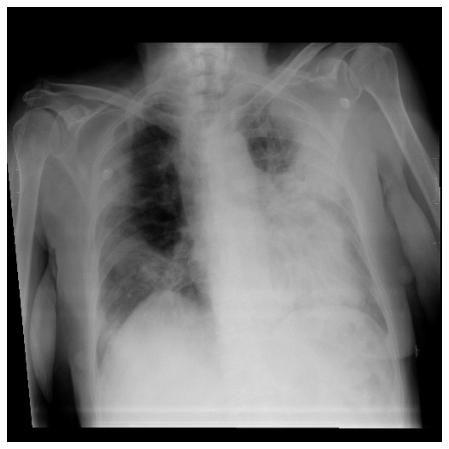

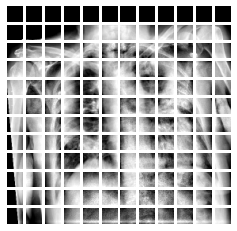

In [17]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]
plt.imshow(image, cmap='gray')
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img,cmap='gray')
    plt.axis("off")

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

In [19]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for _ in range(transformer_layers):

        x1 = layers.BatchNormalization()(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.BatchNormalization()(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
        

    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes, activation='softmax')(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [20]:
def experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_loader ,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=test_loader,
                        callbacks=[checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history

In [21]:
vit_classifier = vit_model()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 256, 256, 1)  3           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 400)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 128)     69760       patches_1[0][0]                  
______________________________________________________________________________________________

In [22]:
history = experiment(vit_classifier)

Epoch 1/100
17/17 [==============================] - 32s 2s/step - loss: 2.4529 - accuracy: 0.3649 - AUC: 0.6135 - val_loss: 1.1983 - val_accuracy: 0.5007 - val_AUC: 0.7400
Epoch 2/100
17/17 [==============================] - 19s 1s/step - loss: 1.4189 - accuracy: 0.4311 - AUC: 0.6892 - val_loss: 1.2590 - val_accuracy: 0.4510 - val_AUC: 0.7119
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 1.2864 - accuracy: 0.4514 - AUC: 0.7065 - val_loss: 1.2259 - val_accuracy: 0.4706 - val_AUC: 0.7299
Epoch 4/100
17/17 [==============================] - 19s 1s/step - loss: 1.2457 - accuracy: 0.4708 - AUC: 0.7201 - val_loss: 1.1994 - val_accuracy: 0.5136 - val_AUC: 0.7492
Epoch 5/100
17/17 [==============================] - 19s 1s/step - loss: 1.2167 - accuracy: 0.4884 - AUC: 0.7344 - val_loss: 1.1855 - val_accuracy: 0.5352 - val_AUC: 0.7553
Epoch 6/100
17/17 [==============================] - 19s 1s/step - loss: 1.2074 - accuracy: 0.5038 - AUC: 0.7375 - val_loss: 1.1847 - v

## 성능평가

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


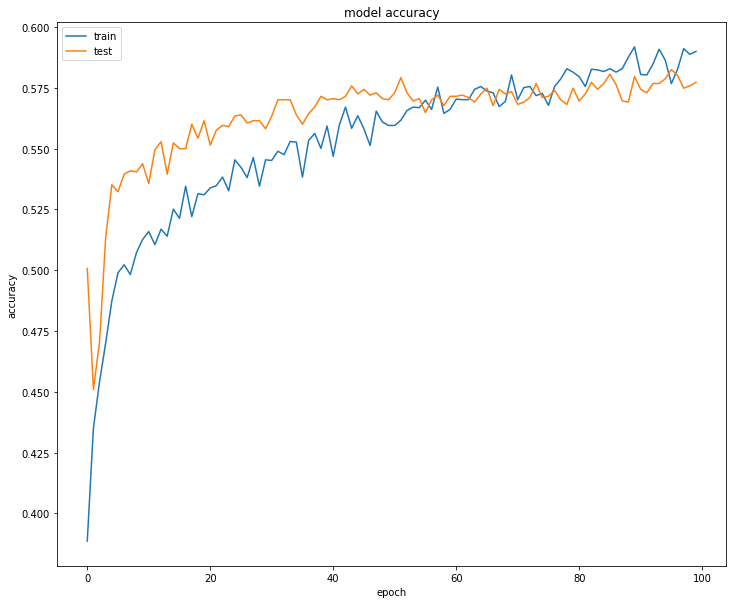

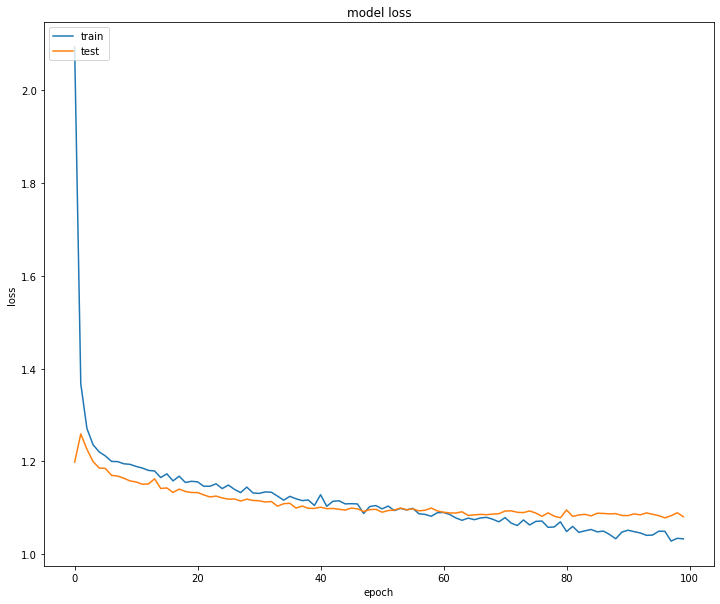

In [23]:

print(history.history.keys())

plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
vit_classifier.load_weights("./tmp/checkpoint")

In [26]:
def get_img_array(img):
    
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

## The Grad-CAM algorithm

In [27]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output#[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,preds=[0,0,0,0], plot=None):


    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")


    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create  RGB heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plot.imshow(superimposed_img)
    plot.set(title =
        "Negative for Pneumonia: \
        {:.3f}\nTypical Appearance: \
        {:.3f}\nIndeterminate Appearance: \
        {:.3f}\nAtypical Appearance: \
        {:.3f}".format(preds[0], \
                    preds[1], \
                    preds[2], \
                    preds[3])
    )
    plot.axis('off')


## Implement

Predicted:
Negative for Pneumonia:     -0.27366840839385986
Typical Appearance: -0.020523712038993835
Indeterminate Appearance:     -0.9218599796295166
Atypical Appearance: -1.8720022439956665


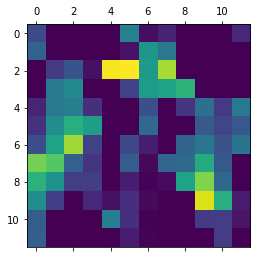

In [29]:
test_image = next(iter(test_loader))[0][5]

img_array =get_img_array(test_image)

last_conv_layer_name = 'layer_normalization'

vit_classifier.layers[-1].activation = None

preds = vit_classifier.predict(img_array)
print("Predicted:\n" +"Negative for Pneumonia: \
    {p1}\nTypical Appearance: {p2}\nIndeterminate Appearance: \
    {p3}\nAtypical Appearance: {p4}".format(p1=preds[0][0], \
                                            p2=preds[0][1],p3=preds[0][2],p4=preds[0][3]))

heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))

plt.matshow(heatmap)

plt.show()

## Heat-Map 

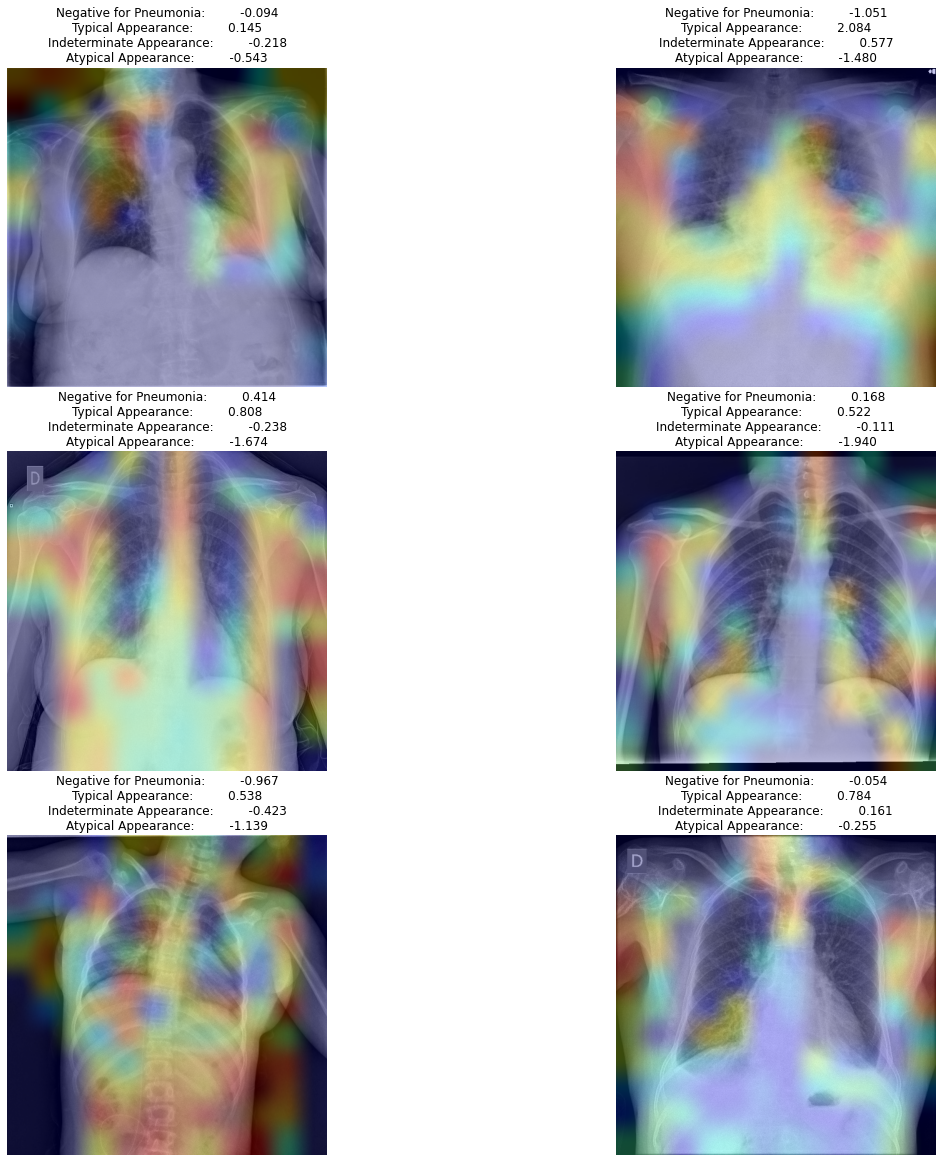

In [34]:
fig, axis = plt.subplots(3, 2, figsize=(20, 20))
for images, ax in zip(next(iter(test_loader))[0][70:77], axis.flat):
    img_array =get_img_array(images)

    vit_classifier.layers[-1].activation = None

    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (12,12))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)

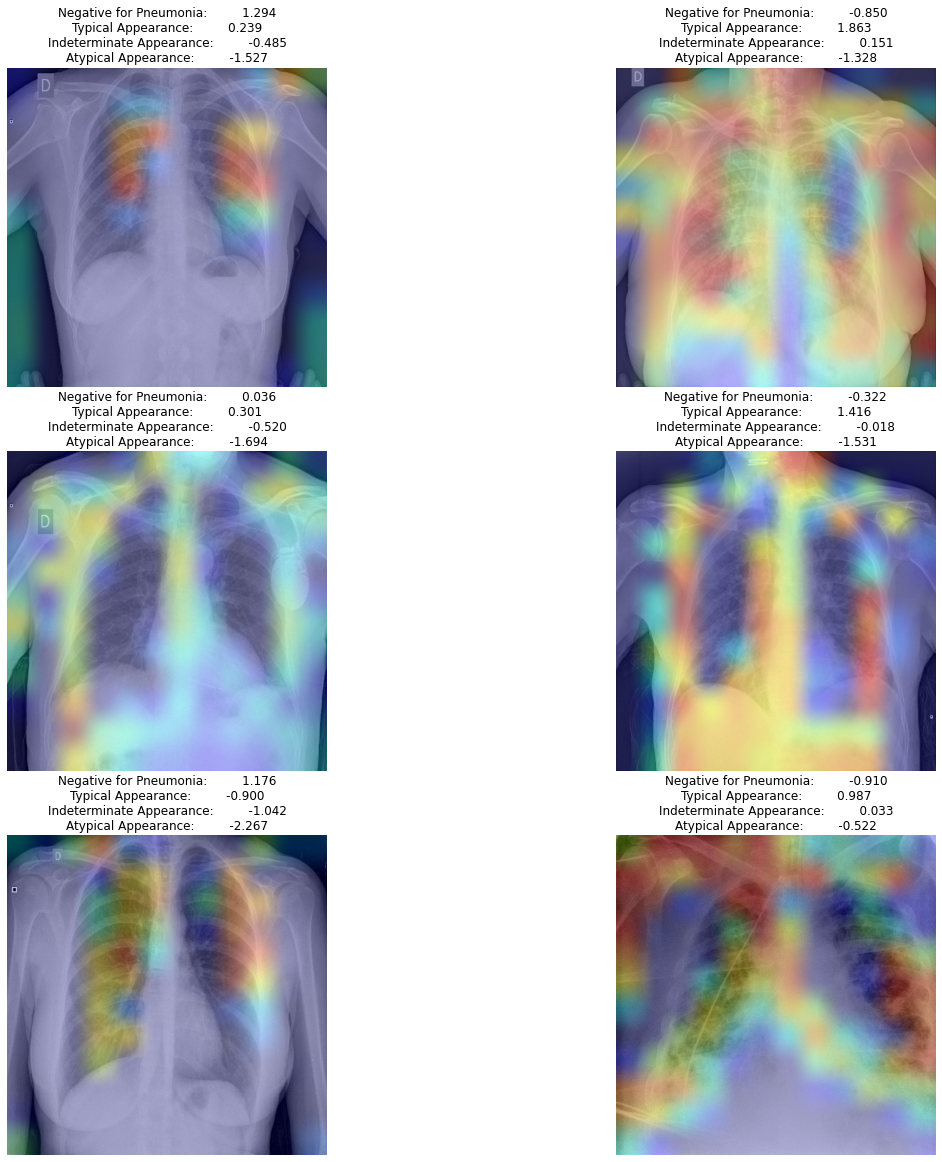

In [35]:
fig, axis = plt.subplots(3, 2, figsize=(20, 20))
for images, ax in zip(next(iter(test_loader))[0][100:107], axis.flat):
    img_array =get_img_array(images)
    vit_classifier.layers[-1].activation = None

    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (12,12))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)